In [69]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib as mpl
import cv2
import json
from ipywidgets import interact
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
label_list = glob.glob('../dataset/label/*')

In [3]:
# json 아닌 label
sum([x.split('.')[-1] != 'json' for x in label_list])

0

In [4]:
print('label 개수 :', len(label_list))

label 개수 : 371


In [5]:
def js_to_img(data_path):
    data_path = data_path.replace('label' , 'defect').replace('json' , 'jpg')
    return data_path

def dict_value_to_int(anno):
    anno = {k: int(v) for k , v in anno.items()}
    x ,y , w, h = anno['x'] , anno['y'] , anno['width'] , anno['height']
    x1 , y1 = x - (w // 2) , y - (h //2)
    x2 , y2 =  x + (w // 2) , y + (h //2)

    return x1 ,y1 , x2 , y2


def yolo_to_cv2_format(anno):
    x_c ,y_c , w, h = anno
    x1 , y1 = x_c - (w // 2) , y_c - (h //2)
    x2 , y2 =  x_c + (w // 2) , y_c + (h //2)

    return x1 ,y1 , x2 , y2

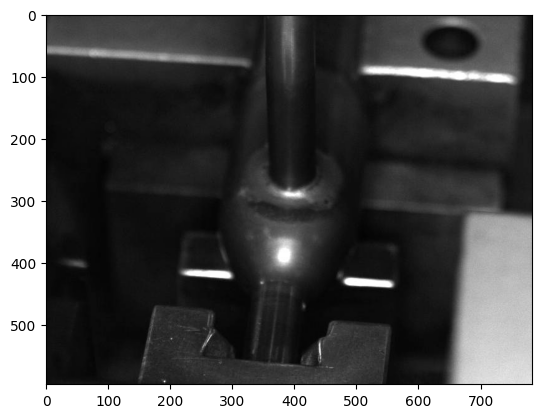

In [6]:
mpl.rcParams.update({"axes.grid" : False, "grid.color": "black"})
img_path = js_to_img(label_list[0])
img = cv2.imread(img_path )
plt.imshow(img)
plt.show()

In [7]:
img.shape

(596, 784, 3)

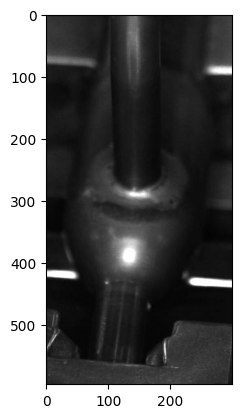

In [8]:
plt.imshow(img[:,250:550,:])

In [9]:
# json file로 부터 img 시각화 하는 방식
def f(idx):
    with open(label_list[idx] , 'r') as file:
        json_file = json.load(file)
    obj_list = json_file[0]['annotations']
    img_path = js_to_img(label_list[idx])
    img = cv2.imread(img_path )
    for obj in obj_list:
        anno = obj['coordinates']
        label_str = obj['label']
        anno = dict_value_to_int(anno)        
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, label_str, (anno[0], anno[1] -5), font, 0.8, (0, 255, 0), 2)
        img = cv2.rectangle(img , (anno[0] , anno[1]) , ( anno[2]  , anno[3]), color = (0,255, 0) , thickness = 1)
    plt.figure(figsize = (15,15))
    plt.imshow(img)
    plt.show()


interact(f , idx=(0 , len(label_list)-1))

interactive(children=(IntSlider(value=185, description='idx', max=370), Output()), _dom_classes=('widget-inter…

<function __main__.f(idx)>

In [10]:
coco = COCO('../info/coco.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [11]:
category_name_list = coco.loadCats(coco.getCatIds())

In [12]:
category_name_list

[{'id': 1, 'name': 'over', 'supercategory': 'defect'},
 {'id': 2, 'name': 'under', 'supercategory': 'defect'},
 {'id': 3, 'name': 'non-welding', 'supercategory': 'defect'}]

In [13]:
# coco format으로 부터 img load 하는 방식
def coco_img(idx):
    img = cv2.imread('../dataset/' + coco.loadImgs(idx)[0]['file_name'])
    annIds = coco.getAnnIds(imgIds=idx, iscrowd=None)
    anns = coco.loadAnns(annIds)
    for obj in anns:
        anno = obj['bbox']
        label_str = coco.loadCats(obj['category_id'])[0]['name']
        anno = yolo_to_cv2_format(anno)        
        font=cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, label_str, (anno[0], anno[1] -5), font, 0.8, (0, 255, 0), 2)
        img = cv2.rectangle(img , (anno[0] , anno[1]) , ( anno[2]  , anno[3]), color = (0,255, 0) , thickness = 1)
    plt.figure(figsize = (15,15))
    plt.imshow(img)
    plt.show()

area max min : (528 , 28258 )


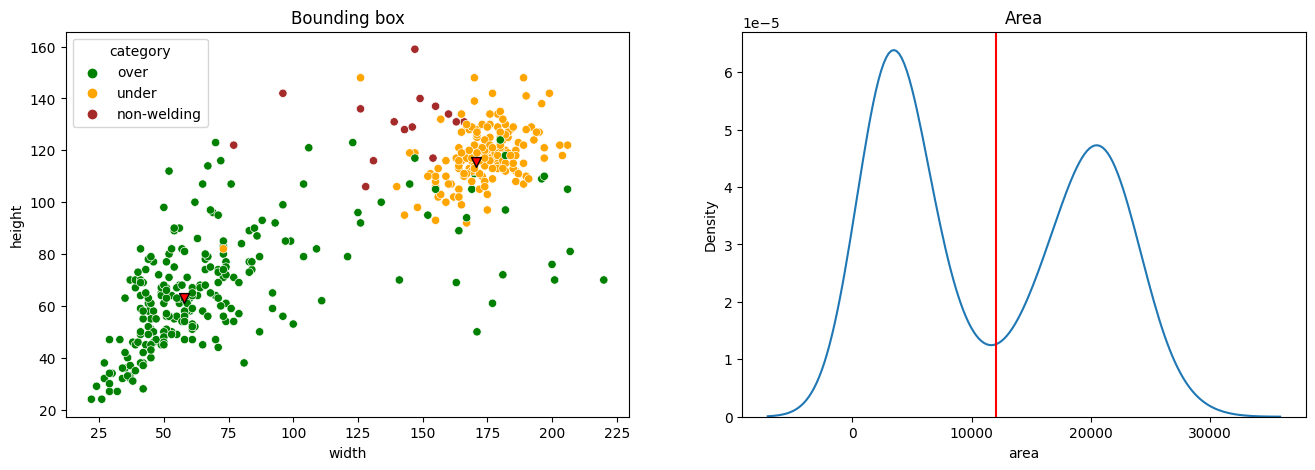

In [164]:
 def get_centroids(coco ,n_clusters , savefig = True):
    id_to_cat = {x['id'] : x['name'] for x in coco.loadCats(coco.getCatIds())}
    bbox_by_cat= [[data['bbox'][2] , data['bbox'][3] ,data['bbox'][2] * data['bbox'][3] , id_to_cat[data['category_id']] ] for data in coco.loadAnns(coco.getAnnIds())]
    df = pd.DataFrame(bbox_by_cat , columns = [ 'width' , 'height','area' , 'category'])

    kmeans_bbox = KMeans(n_clusters= n_clusters , random_state=42)
    kmeans_bbox.fit( df[['width' , 'height']])
    centroids_bbox = kmeans_bbox.cluster_centers_

    kmeans_area = KMeans(n_clusters= n_clusters , random_state=42)
    kmeans_area.fit( df['area'].values.reshape(-1, 1))
    centroids_area = kmeans_area.cluster_centers_

    _ , ax = plt.subplots(1 , 2, figsize = (16,5 ))

    sns.scatterplot(x = 'width' , y = 'height' , hue = 'category' ,data = df  , ax = ax[0] ,palette= ['green' , 'orange' , 'brown'] )
    ax[0].scatter(centroids_bbox[:,0] , centroids_bbox[:,1]  , marker = 'v'  , c ='red'  , edgecolors= 'black' ,  s = 50 )
    ax[0].set_title('Bounding box')

    sns.kdeplot( df['area'])
    ax[1].axvline(x = centroids_area.sum() / 2 , color = 'red')
    ax[1].set_title('Area')

    if savefig:
        plt.savefig('result/centroids.png' , dpi = 300)
    print()
    print(f"area max min : ({df['area'].min()} , {df['area'].max()} )")
    return centroids_bbox , centroids_area

centroids_bbox , centroids_area = get_centroids(coco , 2)

In [158]:
centroids_bbox , centroids_area.sum() / 2

(array([[ 57.62926829,  63.09268293],
        [170.43367347, 115.58673469]]),
 12048.97619047618)